# Fussing about with the newest data

In [34]:
# imports
from importlib import reload
import numpy as np
import os

import h5py
import xarray

from matplotlib import pyplot as plt

from oceancolor.pace import io as pace_io

In [11]:
def calc_Rrs(inp, attrs):
    return attrs['add_offset'] + (inp*attrs['scale_factor'])

# Load up an image

In [3]:
ex_file = os.path.join(os.getenv('OS_COLOR'),
                       'data', 'PACE', 'early',
                       'PACE_OCI.20240416T093158.L2.OC_AOP.V1_0_0.NRT.nc')

## New I/O

In [35]:
reload(pace_io)
xds, flags = pace_io.load_oci_l2(ex_file)

In [36]:
xds

<xarray.Dataset>
Dimensions:     (x: 1709, y: 1272, wl: 184)
Coordinates:
    latitude    (x, y) float32 -45.28 -45.27 -45.26 ... -22.18 -22.16 -22.15
    longitude   (x, y) float32 42.63 42.72 42.81 42.9 ... 67.44 67.51 67.58
    wavelength  (wl) int32 339 341 344 346 348 351 ... 711 712 713 714 717 719
Dimensions without coordinates: x, y, wl
Data variables:
    Rrs         (x, y, wl) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/45)
    title:                             OCI Level-2 Data
    product_name:                      PACE_OCI.20240416T093158.L2.OC_AOP.V1_...
    processing_version:                V1.0.0
    history:                           l2gen par=/data3/sdpsoper/vdc/vpu2/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                42.62585
    geospatial_lon_min:                67.580574
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9927405714988708

In [37]:
xds.Rrs.shape

(1709, 1272, 184)

In [42]:
flags.data.shape

(1709, 1272)

## h5py

In [4]:
f = h5py.File(ex_file, 'r')

In [5]:
f.keys()

<KeysViewHDF5 ['bands_per_pixel', 'geophysical_data', 'navigation_data', 'number_of_bands', 'number_of_cloud_phases', 'number_of_lines', 'number_of_reflectance_location_values', 'number_of_reflective_bands', 'pixel_control_points', 'pixels_per_line', 'processing_control', 'scan_line_attributes', 'sensor_band_parameters', 'wavelength_3d']>

In [6]:
f['geophysical_data'].keys()

<KeysViewHDF5 ['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw', 'l2_flags']>

In [13]:
Rrs_unscaled = f['geophysical_data']['Rrs'][:]

In [8]:
Rrs.shape

(1709, 1272, 184)

In [12]:
Rattrs = f['geophysical_data']['Rrs'].attrs

In [14]:
Rrs = calc_Rrs(Rrs_unscaled, Rattrs)

In [15]:
wave = f['sensor_band_parameters']['wavelength_3d'][:]

In [16]:
flags = f['geophysical_data']['l2_flags'][:]
flags.shape

(1709, 1272)

# Plot a few spectra

In [17]:
gd_idx = np.where(flags == 0)

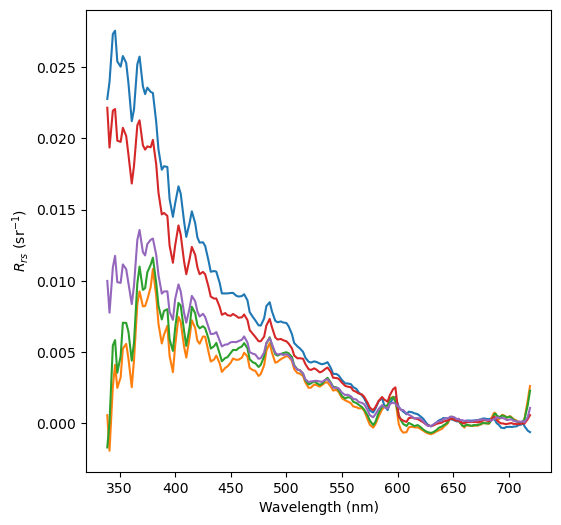

In [29]:
idx = 50

fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()

for idx in [0, 100, 500, 1000, 2000]:
    idx_r, idx_c = gd_idx[0][idx], gd_idx[1][idx]
    ax.plot(wave, Rrs[idx_r,idx_c,:])
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{rs}$ (sr$^{-1}$)')
#
plt.show()

----

# Test

In [73]:
f.attrs.keys()

<KeysViewHDF5 ['title', 'product_name', 'processing_version', 'history', 'instrument', 'platform', 'Conventions', 'license', 'naming_authority', 'id', 'date_created', 'standard_name_vocabulary', 'institution', 'creator_name', 'creator_email', 'creator_url', 'project', 'publisher_name', 'publisher_url', 'publisher_email', 'identifier_product_doi_authority', 'identifier_product_doi', 'processing_level', 'cdm_data_type', 'spatialResolution', '_NCProperties', 'time_coverage_start', 'time_coverage_end', 'start_center_longitude', 'start_center_latitude', 'end_center_longitude', 'end_center_latitude', 'northernmost_latitude', 'southernmost_latitude', 'easternmost_longitude', 'westernmost_longitude', 'geospatial_lat_units', 'geospatial_lon_units', 'geospatial_lat_max', 'geospatial_lat_min', 'geospatial_lon_max', 'geospatial_lon_min', 'startDirection', 'endDirection', 'day_night_flag', 'earth_sun_distance_correction']>

In [63]:
t = f['geophysical_data']['Rrs']

In [70]:
t.compression_opts

4

In [71]:
tmp = Rrs[idx_r,idx_c,:].copy()

In [75]:
t.attrs.keys()

<KeysViewHDF5 ['_Netcdf4Coordinates', 'long_name', 'scale_factor', 'add_offset', 'units', 'standard_name', '_FillValue', 'valid_min', 'valid_max', 'DIMENSION_LIST']>

In [79]:
dict(t.attrs)

{'_Netcdf4Coordinates': array([0, 1, 8], dtype=int32),
 'long_name': b'Remote sensing reflectance',
 'scale_factor': array([2.e-06], dtype=float32),
 'add_offset': array([0.05], dtype=float32),
 'units': b'sr^-1',
 'standard_name': b'surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air',
 '_FillValue': array([-32767], dtype=int16),
 'valid_min': array([-30000], dtype=int16),
 'valid_max': array([25000], dtype=int16),
 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object),
        array([<HDF5 object reference>], dtype=object),
        array([<HDF5 object reference>], dtype=object)], dtype=object)}

SyntaxError: unterminated string literal (detected at line 2) (3849474408.py, line 2)

In [81]:
30000*2e-6

0.06

In [83]:
tmp[0]

-13619

In [25]:
calc_Rrs(-30000, Rattrs)

array([-0.01], dtype=float32)

## xds

In [43]:
xds.wavelength

<xarray.DataArray 'wavelength' (wl: 184)>
array([339, 341, 344, 346, 348, 351, 353, 356, 358, 361, 363, 366, 368,
       371, 373, 375, 378, 380, 383, 385, 388, 390, 393, 395, 398, 400,
       403, 405, 408, 410, 413, 415, 418, 420, 422, 425, 427, 430, 432,
       435, 437, 440, 442, 445, 447, 450, 452, 455, 457, 460, 462, 465,
       467, 470, 472, 475, 477, 480, 482, 485, 487, 490, 492, 495, 497,
       500, 502, 505, 507, 510, 512, 515, 517, 520, 522, 525, 527, 530,
       532, 535, 537, 540, 542, 545, 547, 550, 553, 555, 558, 560, 563,
       565, 568, 570, 573, 575, 578, 580, 583, 586, 588, 591, 593, 596,
       598, 601, 603, 605, 608, 610, 613, 615, 618, 620, 623, 625, 627,
       630, 632, 635, 637, 640, 641, 642, 643, 645, 646, 647, 648, 650,
       651, 652, 653, 655, 656, 657, 658, 660, 661, 662, 663, 665, 666,
       667, 668, 670, 671, 672, 673, 675, 676, 677, 678, 679, 681, 682,
       683, 684, 686, 687, 688, 689, 691, 692, 693, 694, 696, 697, 698,
       699, 701, 702, 703, 704, 706, 707, 708, 709, 711, 712, 713, 714,
       717, 719], dtype=int32)
Coordinates:
    wavelength  (wl) int32 339 341 344 346 348 351 ... 711 712 713 714 717 719
Dimensions without coordinates: wl

In [44]:
(719-339)/184

2.0652173913043477